In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Read data from pandas df
df = pd.read_csv('zillow_rent_cleaned.csv')

In [3]:
df_model = df.copy()

# Convert Date to datetime
df_model['Date'] = pd.to_datetime(df_model['Date'], format='%B %Y', errors='coerce')

# Extract time-based features
df_model['Year'] = df_model['Date'].dt.year
df_model['Month'] = df_model['Date'].dt.month

# Make sure data is sorted by city and time
df_model = df_model.sort_values(['City', 'Year', 'Month'])

# Add lag features
df_model['rent_lag_1'] = df_model.groupby('City')['RentPrice'].shift(1)
df_model['rent_lag_12'] = df_model.groupby('City')['RentPrice'].shift(12)

# Drop rows with missing lag values
df_model = df_model.dropna().reset_index(drop=True)

In [4]:
X = df_model[['Year', 'Month', 'Population Rank', 'State', 'Metro']]
y = df_model['RentPrice']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [6]:
numeric_features = ['Year', 'Month', 'Population Rank']
categorical_features = ['State', 'Metro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [7]:
linreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Population Rank']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'Metro'])])),
                ('model', LinearRegression())])

In [8]:
y_pred = linreg_pipeline.predict(X_test)

print("Linear Regression Results")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))


Linear Regression Results
MAE : 254.73009588063985
RMSE: 495.08390147640256
R²  : 0.4328481707575066


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [12]:
X_sub = X_train[:10000]  
y_sub = y_train[:10000]

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=1
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # ColumnTransformer
    ('model', rf)
])

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    random_state=42
)

rf_search.fit(X_sub, y_sub)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['Year',
                                                                                'Month',
                                                                                'Population '
                                                                                'Rank']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['State',
                                                                                'Metro'])])),
                                             ('model',
                                              RandomForestRegressor(n_jobs=1,
                                                                    random_state=42))]),
                   n_iter=5, n_jobs=1,
                   param_distributions={'model__max_depth': [10, 20, None],
                                        'model__min_samples_split': [2, 5],
                                        'model__n_estimators': [50, 100]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [13]:
y_pred_rf = rf_search.predict(X_test)

In [14]:
y_pred_rf

array([1197.22,  835.34,  969.56, ..., 1203.62, 1199.54, 1201.17])

In [15]:
print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 346.7995532249566
RMSE: 594.8993957581935
R²: 0.1811039366453241


In [16]:
# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

In [17]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # ColumnTransformer with OHE
    ('model', gbr)
])

param_grid_gbr = {
    'model__n_estimators': [30, 50],
    'model__learning_rate': [0.1],
    'model__max_depth': [3]
}

gbr_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid_gbr,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

gbr_search.fit(X_train, y_train)

y_pred_gbr = gbr_search.predict(X_test)

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [18]:
y_pred_gbr

array([1144.72756452, 1250.30665299, 1250.30665299, ..., 1265.07569373,
       1265.07569373, 1265.07569373])

In [19]:
print("Gradient Boosting")
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", mean_squared_error(y_test, y_pred_gbr, squared=False))
print("R²:", r2_score(y_test, y_pred_gbr))

Gradient Boosting
MAE: 300.146920710817
RMSE: 541.8231780559732
R²: 0.3207073956504939


In [20]:
# Find the latest Year and Month in your dataset
last_year = df_model['Year'].max()
last_month = df_model[df_model['Year'] == last_year]['Month'].max()

# Initialize
future_years = []
future_months = []

year, month = last_year, last_month

# Forecast next 12 months
for _ in range(12):
    month += 1
    if month > 12:
        month = 1
        year += 1
    future_years.append(year)
    future_months.append(month)

In [21]:
future_df = pd.DataFrame({
    'Year': future_years,
    'Month': future_months,
    'Population Rank': [df_model[df_model['City']=='Los Angeles']['Population Rank'].median()] * 12,
    'State': ['CA'] * 12,
    'Metro': ['Los Angeles'] * 12
})

In [22]:
future_df['Predicted_Rent'] = linreg_pipeline.predict(future_df)
future_df

,Year,Month,Population Rank,State,Metro,Predicted_Rent
0,2017,2,2.0,CA,Los Angeles,2796.742207
1,2017,3,2.0,CA,Los Angeles,2799.180181
2,2017,4,2.0,CA,Los Angeles,2801.618154
3,2017,5,2.0,CA,Los Angeles,2804.056127
4,2017,6,2.0,CA,Los Angeles,2806.494100
5,2017,7,2.0,CA,Los Angeles,2808.932073
6,2017,8,2.0,CA,Los Angeles,2811.370047
7,2017,9,2.0,CA,Los Angeles,2813.808020
8,2017,10,2.0,CA,Los Angeles,2816.245993
9,2017,11,2.0,CA,Los Angeles,2818.683966


/var/folders/ky/xqwppm3x1mbb4h8dcfjwqx740000gn/T/ipykernel_14674/2239608338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical['Date'] = pd.to_datetime(


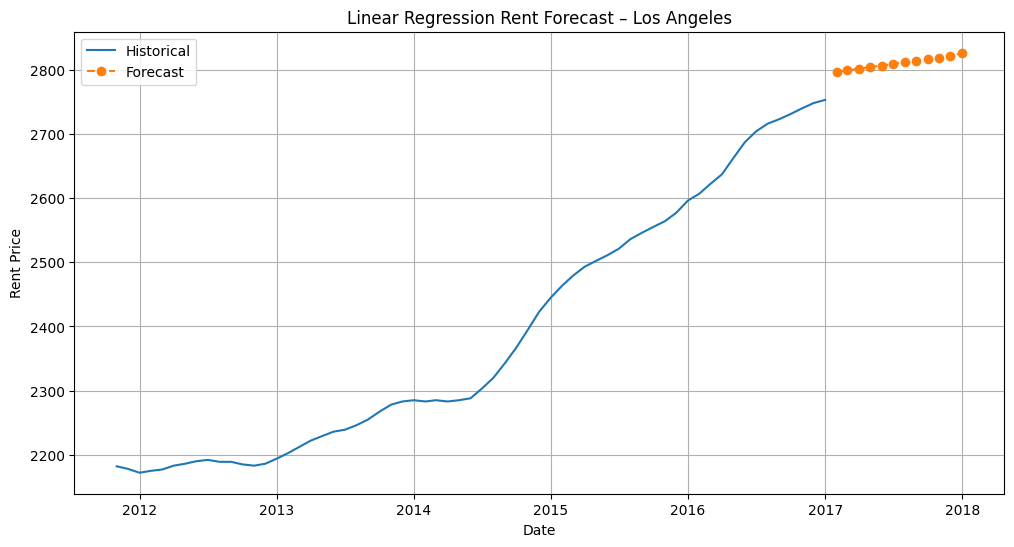

In [23]:
historical = df_model[df_model['City']=='Los Angeles']
historical['Date'] = pd.to_datetime(
    dict(year=historical['Year'], month=historical['Month'], day=1)
)

future_df['Date'] = pd.to_datetime(
    dict(year=future_df['Year'], month=future_df['Month'], day=1)
)

plt.figure(figsize=(12,6))
plt.plot(historical['Date'], historical['RentPrice'], label='Historical')
plt.plot(future_df['Date'], future_df['Predicted_Rent'],
         linestyle='--', marker='o', label='Forecast')

plt.title('Linear Regression Rent Forecast – Los Angeles')
plt.xlabel('Date')
plt.ylabel('Rent Price')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression was selected as the final model because it provides the best balance between predictive performance, interpretability, and robustness under a time-aware evaluation. Although overall R² decreased when incorporating categorical city-level features and forecasting future periods, Linear Regression consistently captured the underlying temporal trend in rental prices and performed competitively against more complex tree-based models. Given the linear nature of rent growth over time and the academic focus on interpretability, Linear Regression was chosen as the final forecasting model.